# Myeloids\CD8 Cutaneous Vs. Mucosal analysis

##### 1. Melanoma association with clusters analysis - 
Each cluster see the number of cells correspond to cutaneous patients vs. number of cells corespond to mucosal patients.

##### 2. GEP association with melanoma -
Per program, take all usage values of cells coming from cutaneous patients vs. mucosal patients, and perform Wilcoxon ranksum test.

##### 3. GEP association with melanoma (2) - 
Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between cutaneous and mucosal patients.


In [1]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *
import scipy.stats as stats

Helper functions:

In [2]:
def print_pvals(pvals, n_groups):
    
    pvals_df = pd.DataFrame([[v[0], int(v[1])] for v in transpose([pvals, range(1, n_groups+1)])], columns=['pval', 'group'])
    plt.figure(figsize=(8, 6), dpi=80);

    pvals = pvals_df[["group", "pval"]].values
    small_pvals = pvals[pvals[:,1]<0.05]
    big_pvals = pvals[pvals[:,1]>=0.05]


    plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1]);
    plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1]);

    ax = plt.plot([0,n_groups+1],[0.05,0.05], color='y');
    plt.xticks(np.arange(1, n_groups+1));
    plt.yticks([0.05, 1]);
    plt.xlim((0,n_groups+1));
    plt.title('p-values');

    for coord in pvals:
        plt.text(coord[0], coord[1], '{}'.format(int(coord[0])));
        
def get_coorected_label(x ,p_value_dic):
    pvalue = p_value_dic[x]
    return str(x) + '\n'+''.join(['*' for sig in [0.05, 0.005, 0.0005] if pvalue < sig])

def save_pvals(path, pvals, corrected_pvals, GROUP_NAME):
    pval_df = pd.DataFrame(np.array([pvals[:,0], pvals[:,1], corrected_pvals[:,1]]).T, columns=[GROUP_NAME, 'pval', 'corrected_pval'])#.sort_values('pval')
    pval_df[GROUP_NAME] = pval_df[GROUP_NAME].astype(int)
    pval_df.to_excel(path, index=False)


### Specify clinical table and set output path
clinical table can be 1|2|3
* 1 - NR mucosal vs NR cutaneous
* 2 - NR mucosal vs R cutaneous
* 3 - NR mucosal vs NR & R cutaneous

OUTPUT PATH - all marker list/heatmaps/figures will be saved there

In [3]:
# FOLDER_PATH = r'/storage/md_keren/shitay/outputs/response_analysis/cohort_4.11.21/4.1.22/NR_mucosal_vs_R_AND_NR_cutaneous'
FOLDER_PATH = r'/storage/md_keren/shitay/outputs/response_analysis/cohort_4.11.21/4.1.22/NR_mucosal_vs_NR_cutaneous'
CLINICAL_TABLE_NUM = 3

# create_folder(FOLDER_PATH)

##### Loads clinical table to get labels - Mucosal/Cutaneous

In [4]:
#melanoma_clinical_data = get_clinical_data() #ICI=True, after_biopsy='ICI')
melanoma_clinical_data = get_constant_cohort(CLINICAL_TABLE_NUM)
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')
print(f'Num of samples in table is {len(melanoma_clinical_data)}')
display(melanoma_clinical_data.head(10))
res_melanoma_clinical_data['Melanoma type'].value_counts()

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/Melanoma_clinical_data_12.21_unportected.csv

and labels:
/storage/md_keren/shitay/Data/tables/clinical_labels.csv
Num of samples in table is 18


,index,Patient id,Melanoma type,response,prior to biopsy,after biopsy,ICI,BRAF
2,2,M99,Mucosal,NR,ICI,other therapy,True,False
9,9,M106,Cutaneous,NR,ICI,other therapy,True,False
10,10,M107,Cutaneous,NR,ICI,other therapy,True,False
14,14,M111,Mucosal,NR,ICI,other therapy,True,False
20,20,M120,Cutaneous,NR,ICI,other therapy,True,True
28,28,M128,Mucosal,NR,other therapy,ICI,True,False
30,30,M130,Cutaneous,R,other therapy,ICI,True,False
31,31,M131,Cutaneous,R,ICI,other therapy,True,False
36,36,M136,Mucosal,NR,ICI,other therapy,True,False
37,37,M137,Cutaneous,R,ICI,other therapy,True,True


Cutaneous    14
Mucosal       4
Name: Melanoma type, dtype: int64

#### Builds Mucosal/Cutaneous sample list

In [5]:
cutaneous_samples = res_melanoma_clinical_data[res_melanoma_clinical_data['Melanoma type'] == 'Cutaneous'].index.tolist()
mucosal_samples = res_melanoma_clinical_data[res_melanoma_clinical_data['Melanoma type'] == 'Mucosal'].index.tolist()
no_used_samples = res_melanoma_clinical_data[res_melanoma_clinical_data['Melanoma type'] == 'other'].index.tolist()

print(f'number cutaneous_samples: {len(cutaneous_samples)}')
print(f'number mucosal_samples: {len(mucosal_samples)}')
print(f'number of \'other\' samples: {len(no_used_samples)}')


number cutaneous_samples: 14
number mucosal_samples: 4
number of 'other' samples: 0


#### Loads Mucosal & Cutaneous cohort:

In [295]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/4.11.21/cohort_normalized_4.11.21_protein_coding_genes.pkl'

cohort = pickle.load(open(COHORT_PATH, 'rb'))
# tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)
# immune_cohort = cohort.filter_cells_by_property('is_immune', True)

#  1. Myeloid\CD8 Differential expression analysis

Specify group: myeloids or CD8 and will find markers across all (protein coding) genes and draw heatmaps. - DONE

In [305]:
GROUP = 'CYTOTOXIC_T_CELLS' # 'MYELOIDS' or 'CYTOTOXIC_T_CELLS'

from utilities.droplet_dataset import get_requested_subset
sub_cohort = get_requested_subset(cohort, GROUP)

Will be performed on cytotoxic T cells


In [306]:
cutaneous_samples_indices = [s in cutaneous_samples for s in sub_cohort.samples]
mucosal_samples_indices =[s in mucosal_samples for s in sub_cohort.samples]
no_used_samples_indices = [s in no_used_samples for s in sub_cohort.samples]

print(f'number of cells in cutaneous_samples_indices: {sum(cutaneous_samples_indices)}')
print(f'number of cells in mucosal_samples_indices: {sum(mucosal_samples_indices)}')
print(f'number of cells in no_used_samples_indices: {sum(no_used_samples_indices)}')

cutaneous_cells = sub_cohort[cutaneous_samples_indices]
mucosal_cells = sub_cohort[mucosal_samples_indices]

number of cells in cutaneous_samples_indices: 9468
number of cells in mucosal_samples_indices: 2085
number of cells in no_used_samples_indices: 0


#### Conduct fisher's exact test to find markers of response in tumor cells:

In [307]:
cutaneous_markers = find_marker_genes_in_cluster(cutaneous_cells, mucosal_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)
print(f'Number of markers found in cutaneous samples: {len(cutaneous_markers)}')

Number of markers found in cutaneous samples: 407


#### Conduct fisher's exact test to find markers of non-response in tumor cells:

In [313]:
mucosal_markers = find_marker_genes_in_cluster(mucosal_cells, cutaneous_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)
print(f'Number of markers found in mucosal samples: {len(mucosal_markers)}')

Number of markers found in mucosal samples: 829


#### Builds heatmap:

In [335]:
number_of_markers = 50

In [336]:
# arrange cells indices by mean expression
cutaneous_markers_indices = np.array([sub_cohort.features.index(f) for f in cutaneous_markers.iloc[:number_of_markers]['features']])
cutaneous_cells_indices = np.flip(np.argsort(cutaneous_cells.counts[:, cutaneous_markers_indices].mean(axis=1)))

mucosal_markers_indices = [sub_cohort.features.index(f) for f in mucosal_markers.iloc[:number_of_markers]['features']]
mucosal_cells_indices = np.flip(np.argsort(mucosal_cells.counts[:, mucosal_markers_indices].mean(axis=1)))

In [337]:
genes_indices = [sub_cohort.features.index(f) for f in cutaneous_markers.iloc[:number_of_markers]['features']] + [sub_cohort.features.index(f) for f in mucosal_markers.iloc[:number_of_markers]['features']]
arr_heatmap = np.concatenate([cutaneous_cells.counts[cutaneous_cells_indices][:, genes_indices], mucosal_cells.counts[mucosal_cells_indices][:, genes_indices]])
heatmap = np.zeros_like(arr_heatmap)
heatmap[arr_heatmap > 1] = 1
arr_heatmap = scipy.stats.zscore(arr_heatmap, axis=0, ddof=1)

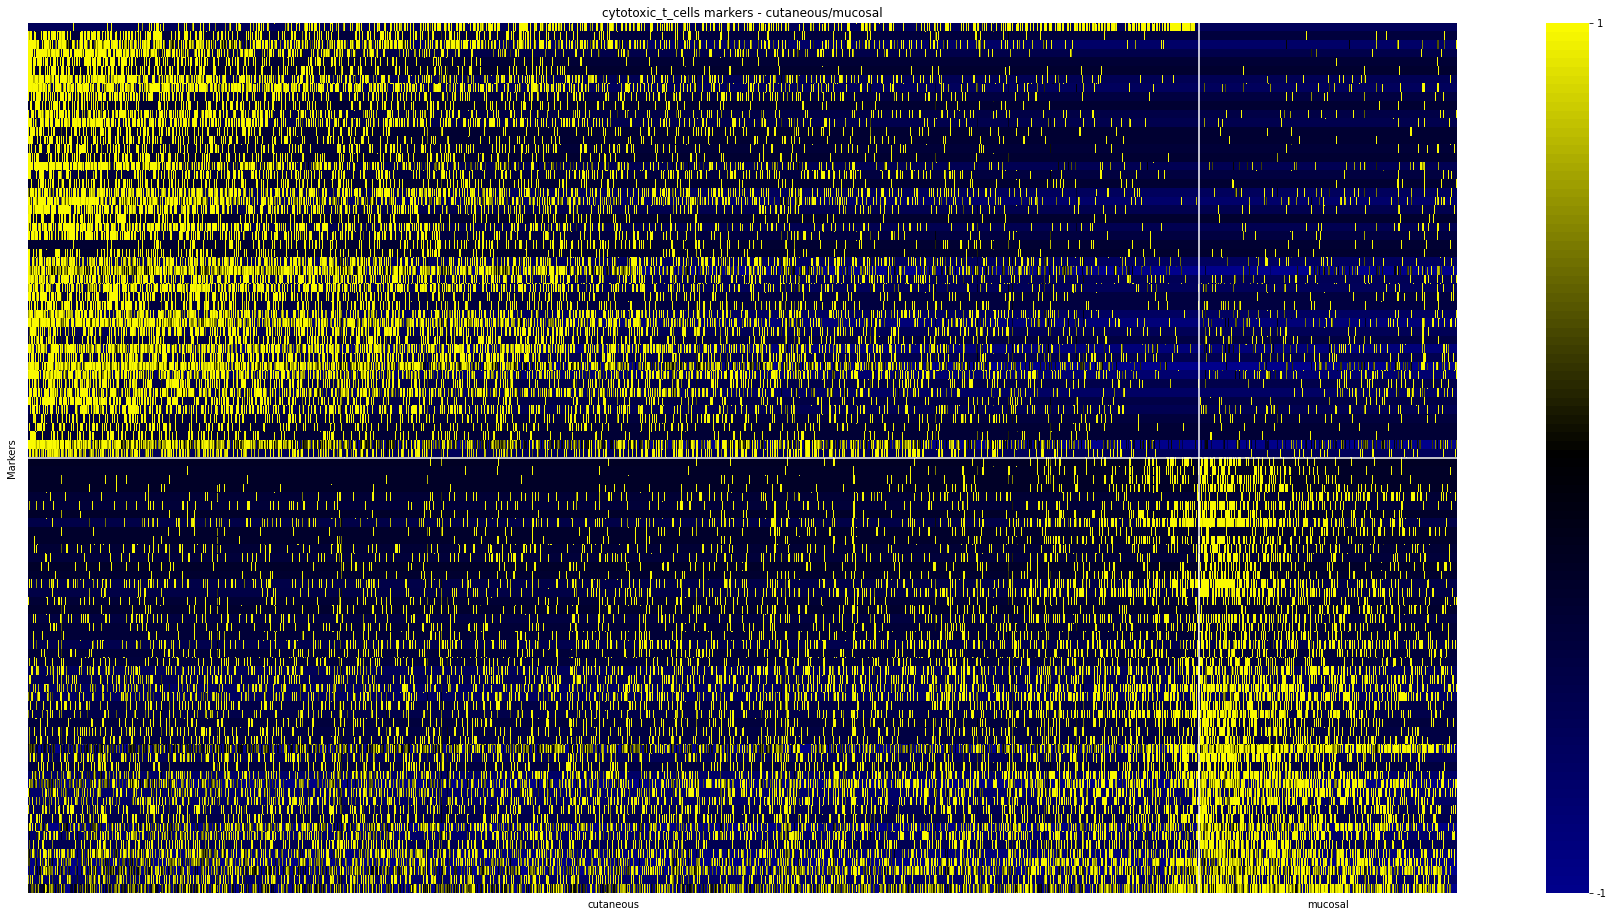

In [338]:
cmap = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/immune/heatmap/colorbar.pkl', 'rb'))
fig, ax = plt.subplots(1)
# fig.set_size_inches(10, 5)
fig.set_size_inches(32, 16)

sb_out = sb.heatmap(arr_heatmap.T, vmin=-1, vmax=1, cmap=cmap);
cbar = sb_out.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels([-1, 1])


sb_out.set_xticks([int(cutaneous_cells.number_of_cells/2), cutaneous_cells.number_of_cells+int(mucosal_cells.number_of_cells/2) ]) # <--- set the ticks first
sb_out.set_xticklabels(['cutaneous', 'mucosal'], rotation='horizontal')


# sb_out.set(xticklabels=[])
sb_out.set(yticklabels=[])
sb_out.tick_params(bottom=False, left=False)

ax.axhline(number_of_markers, color='white')
ax.axvline(cutaneous_cells.number_of_cells, color='white')
group_title = GROUP.lower()
ax.set_title(f"{group_title} markers - cutaneous/mucosal");
# ax.set_xlabel('cutaneous            non-response');
ax.set_ylabel('Markers');

In [340]:
OUTPUT_PATH = join(FOLDER_PATH, f'{group_title}')
FILE_NAME = fr'marker_heatmap.png'

create_folder(OUTPUT_PATH)
fig.savefig(join(OUTPUT_PATH, FILE_NAME))
cutaneous_markers.to_excel(join(OUTPUT_PATH, r'cutaneous_markers.xlsx'))
mucosal_markers.to_excel(join(OUTPUT_PATH, r'mucosal_markers.xlsx'))

# 2. Melanoma association with myeloid\CD8 clusters analysis

Each cluster see the number of cells correspond to cutaneous patients vs. number of cells corespond to mucosal patients.


In [97]:
GROUP = 'CYTOTOXIC_T_CELLS' # 'MYELOIDS' or 'CYTOTOXIC_T_CELLS'

if GROUP=='CYTOTOXIC_T_CELLS':
    clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/subcohort_1.1.22_run_1.1.22/subcohort_CD8_1.1.22_clusters_mapping.csv'
else:
    clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/subcohort_1.1.22_run_1.1.22/subcohort_myeloid_1.1.22_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

##### Takes only samples that appear in the clinical table

In [98]:
clusters_barcodes_mapping_df = clusters_barcodes_mapping_df[clusters_barcodes_mapping_df["Sample"].isin(melanoma_clinical_data['Patient id'])]

###### cluster visualizations

In [99]:
df = clusters_barcodes_mapping_df.drop(columns=['Unnamed: 0'])
df['Melanoma type'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['Melanoma type'])

n_cutaneous = df['Melanoma type'].value_counts()['Cutaneous']
n_mucosal = df['Melanoma type'].value_counts()['Mucosal']

In [100]:
clusters = df['Cluster'].unique()

cutaneous_counts = np.zeros(len(clusters))
mucosal_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    melanoma_type = df[df['Cluster']==cluster]['Melanoma type']
    cutaneous_counts[idx] = sum(melanoma_type=='Cutaneous')
    mucosal_counts[idx] = sum(melanoma_type=='Mucosal')


RanksumsResult(statistic=1.9844852778949553, pvalue=0.04720176769014221)
WilcoxonResult(statistic=3.0, pvalue=0.3125)


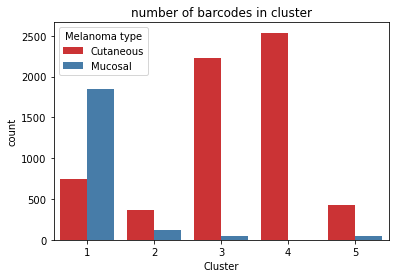

In [101]:

sns.reset_orig() # reset size of figure
ax = sns.countplot(x="Cluster", hue='Melanoma type', data=df, palette="Set1").set(title='number of barcodes in cluster')

print()
print(ranksums(cutaneous_counts, mucosal_counts))
print(wilcoxon(cutaneous_counts, mucosal_counts))

##### Normalized by group size (number of barcodes in group - Mucosal/Cutaneous):

In [102]:
df = df[df['Melanoma type']!='other']

Normalized by number of barcodes in group (Mucosal/Cutaneous):

RanksumsResult(statistic=1.5666989036012806, pvalue=0.11718508719813801)
WilcoxonResult(statistic=5.0, pvalue=0.625)


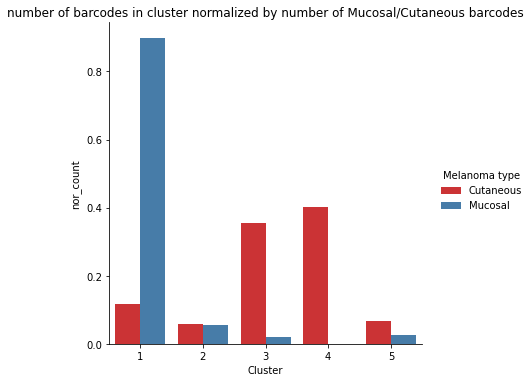

In [103]:
cutaneous_nor = cutaneous_counts/n_cutaneous
mucosal_nor = mucosal_counts/n_mucosal

print('Normalized by number of barcodes in group (Mucosal/Cutaneous):')

count_df = df.groupby(['Melanoma type', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_cutaneous if x['Melanoma type']=='Cutaneous' else x['count']/n_mucosal ,axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Melanoma type', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of Mucosal/Cutaneous barcodes')
    
print()
print(ranksums(cutaneous_nor, mucosal_nor))
print(wilcoxon(cutaneous_nor, mucosal_nor))

##### Normalized by number of cells in cluster:


RanksumsResult(statistic=2.40227165218863, pvalue=0.016293603621028527)
WilcoxonResult(statistic=1.0, pvalue=0.125)


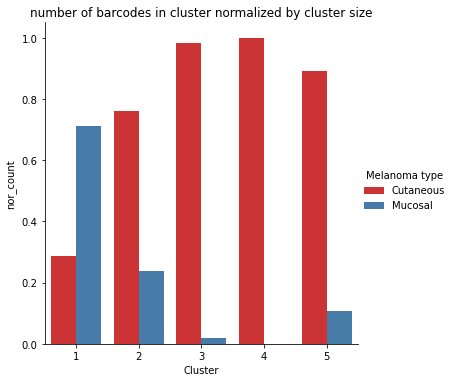

In [104]:
cutaneous_nor = cutaneous_counts/(cutaneous_counts + mucosal_counts) #n_cutaneous
mucosal_nor = mucosal_counts/(cutaneous_counts + mucosal_counts) #n_mucosal


    
df_nor_count = df.groupby(['Melanoma type', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
df_nor_count['nor_count'] = df_nor_count.apply(lambda x: x['count']/df_nor_count[df_nor_count['Cluster']==x['Cluster']]['count'].sum(), axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Melanoma type', data=df_nor_count, palette="Set1").set(title='number of barcodes in cluster normalized by cluster size')
print()    
print(ranksums(cutaneous_nor, mucosal_nor))
print(wilcoxon(cutaneous_nor, mucosal_nor))

# 2.1. patient fraction over clusters - ranksum test

In [105]:
sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index().drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['Cluster']).drop(columns=['index'])

sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Melanoma type'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['Melanoma type'])

See how many samples (Cutaneous/Mucosal) have cells in each cluster:

In [106]:
sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index().drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['Cluster']).drop(columns=['index'])

sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Melanoma type'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['Melanoma type'])

sample_fractions_df = sample_fractions_df.drop(columns=[ii for ii in ['Unnamed: 0', 'Unnamed: 0.1', 'index'] if ii in sample_fractions_df.columns])

Add zero fraction samples:

With corrected pvals!


<Figure size 480x240 with 0 Axes>

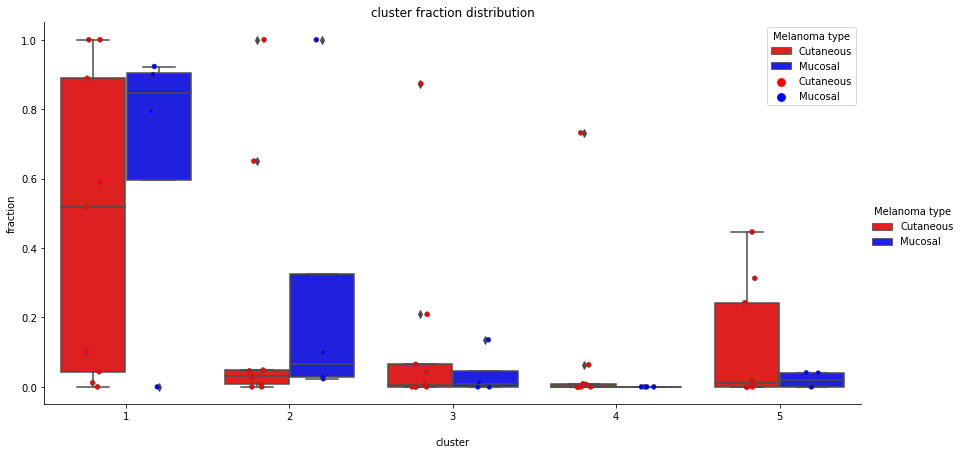

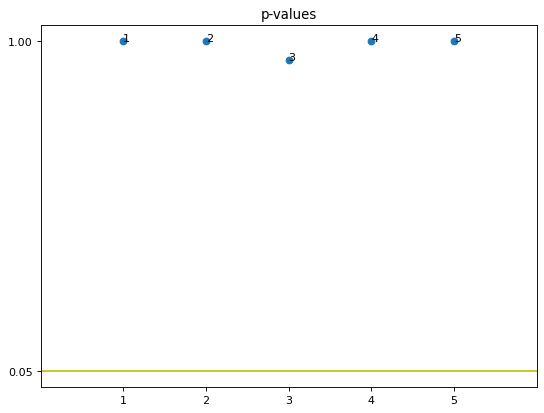

In [107]:
full_sample_fractions_df = pd.DataFrame(sample_fractions_df[sample_fractions_df['Melanoma type']!='other'])
samples_in_clusters = full_sample_fractions_df[["Sample", 'Cluster']].values.tolist()
samples = cutaneous_samples + mucosal_samples
dic_response = {ss:'Cutaneous' for ss in cutaneous_samples}
dic_response.update({ss:'Mucosal' for ss in mucosal_samples})
all_pairs = [[s, cl] for cl in clusters for s in samples]
pairs_need_to_add = [pair for pair in all_pairs if not pair in samples_in_clusters]
for sample, cluster in pairs_need_to_add:
    full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, 0, 0, dic_response[sample]]], columns=full_sample_fractions_df.columns))
    


pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = full_sample_fractions_df[full_sample_fractions_df["Cluster"] == cluster]
    cutaneous_fractions = cluster_df[cluster_df['Melanoma type'] == 'Cutaneous']['fraction'].values
    mucosal_fractions = cluster_df[cluster_df['Melanoma type'] == 'Mucosal']['fraction'].values
    res = ranksums(cutaneous_fractions, mucosal_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
print('With corrected pvals!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T

sns.reset_orig()
plt.figure(figsize=(6, 3), dpi=80)
full_sample_fractions_df = full_sample_fractions_df.sort_values('Cluster')
full_sample_fractions_df['cluster'] = full_sample_fractions_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
ax = sns.catplot(kind="box", x='cluster', y='fraction', hue='Melanoma type', data=full_sample_fractions_df, palette={'Cutaneous':'r', 'Mucosal':'b'},height=6, aspect=2.0).set(title="cluster fraction distribution")
sns.stripplot(x='cluster', y='fraction', hue='Melanoma type', data=full_sample_fractions_df,
              jitter=True, dodge=True, linewidth=0.5, palette={'Cutaneous':'r', 'Mucosal':'b'});


print_pvals(corrected_pvals[:,1], len(clusters))


In [108]:
######### save ########

# if GROUP=='CYTOTOXIC_T_CELLS':
#     OUTPUT_PATH = join(FOLDER_PATH, 'cytotoxic_t_cells')
# else:
#     OUTPUT_PATH = join(FOLDER_PATH, 'myeloids')
# create_folder(OUTPUT_PATH)
# OUTPUT_PATH = join(OUTPUT_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)

# save_pvals(join(OUTPUT_PATH, 'cluster_fractions_ranksum_test_pvals.xlsx'), pvals, corrected_pvals, 'cluster')
# ax.savefig(join(OUTPUT_PATH, 'cluster_fractions_ranksum_test.png'), dpi = 150)
# print(f'saved in {OUTPUT_PATH}')

In [ ]:
# cluster_idx = 9

# pd.set_option('display.max_rows', None)
# display(full_sample_fractions_df[full_sample_fractions_df['Cluster']==cluster_idx].sort_values('fraction')[['Melanoma type', 'fraction']])#['Response'].tolist()
# pd.set_option('display.max_rows', 10)

# 2.2 clusters analysis - Fisher exact's test

With corrected pvals!


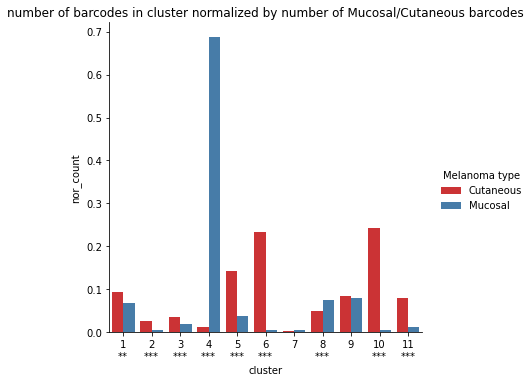

In [19]:
n_cells_in_group_df = df.groupby(['Melanoma type']).agg(count=('Barcode', 'count')).reset_index()
n_cells_in_cluster_df = df.groupby(['Cluster', 'Melanoma type']).agg(count=('Barcode', 'count')).reset_index()
pvals = []
for cluster_idx in sorted(df['Cluster'].unique().tolist()):
    n_cells_g1_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Melanoma type']=='Cutaneous')]['count'].values,np.array([0])))[0]
    n_cells_g1_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Melanoma type']=='Cutaneous']['count'].values[0] - n_cells_g1_in_cluster
    
    n_cells_g2_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Melanoma type']=='Mucosal')]['count'].values,np.array([0])))[0]
    n_cells_g2_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Melanoma type']=='Mucosal']['count'].values[0] - n_cells_g2_in_cluster
    oddsratio, pvalue = stats.fisher_exact([[n_cells_g1_in_cluster, n_cells_g2_in_cluster],[n_cells_g1_not_in_cluster, n_cells_g2_not_in_cluster]])
    pvals.append([cluster_idx, pvalue])
pvals = np.array(pvals)

# Correct pvals
print('With corrected pvals!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T


cutaneous_nor = cutaneous_counts/n_cutaneous
mucosal_nor = mucosal_counts/n_mucosal
count_df = df.groupby(['Melanoma type', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_cutaneous if x['Melanoma type']=='Cutaneous' else x['count']/n_mucosal ,axis=1)
count_df['cluster'] = count_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
ax = sns.catplot(kind="bar", x='cluster', y='nor_count', hue='Melanoma type', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of Mucosal/Cutaneous barcodes')
   
# print_pvals(pvals[:,1], len(clusters))

In [20]:
######### save ########
# if GROUP=='CYTOTOXIC_T_CELLS':
#     OUTPUT_PATH = join(FOLDER_PATH, 'cytotoxic_t_cells')
# else:
#     OUTPUT_PATH = join(FOLDER_PATH, 'myeloids')
# create_folder(OUTPUT_PATH)
# OUTPUT_PATH = join(OUTPUT_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)

# save_pvals(join(OUTPUT_PATH, 'clustering_fisher_test_pvals.xlsx'), pvals, corrected_pvals, 'cluster')
# ax.savefig(join(OUTPUT_PATH, 'clustering_fisher_test.png'), dpi = 150)
# print(f'saved in {OUTPUT_PATH}')

# Debug

In [122]:
normalized_usage_matrix.values[:1000].shape
threshold = 0.1
sort_dic(Counter(np.sum(normalized_usage_matrix.values[:200]>threshold, axis=1)))

{1: 3, 2: 45, 3: 111, 4: 36, 5: 5}

In [3]:
df = get_clinical_subdata(n_R_muc=0, n_NR_muc=4, n_R_cut=0, n_NR_cut=0, ICI=True, only_metastasis_sample=True, therapy_translator=therapy_IPI_transletror)
# get_clinical_table_size(response='R', melanoma_type=['Cutaneous'], ICI=True, only_metastasis_sample=True, therapy_translator=therapy_IPI_transletror)
df

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/Melanoma_clinical_data_OCT_unportected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx
There are no enough samples as you requested! valid the number that you ask!


In [32]:
# n_samples = 71
# pd.set_option('display.max_rows', None)

# melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
# # melanoma_clinical_data['Therapy after biopsy'].iloc[:46]

# def translate(x):
#     if not x or str(x)=='nan':
#         return 'nothing'
#     x = str(x).lower()
#     if 'ipi' in x or 'pembro' in x or 'pembo' in x or 'nivo' in x or 'apd' in x or 'pd1' in x:
#         return 'ICI'
    
#     elif 'enco' in x or 'd+t' in x:
#         return 'other therapy'
    
#     elif 'radiation' in x:
#         return 'other therapy'
    
#     elif 'carbo' in x or 'imatinib' in x or 'tmz' in x or 'tvec' in x or 'cdk4/6' in x :
#         return 'other immune therapy'
    
#     elif 'surgical ' in x or 'surgery ' in x or 'neodajuvant' in x:
#         return 'other therapy'
       
#     else:
#         return x
    
# # Counter(melanoma_clinical_data['Therapy(ies) prior to biopsy'].iloc[:46])
# x = melanoma_clinical_data['Therapy(ies) prior to biopsy'].iloc[:n_samples].apply(lambda x: translate(x))
# y = melanoma_clinical_data['Therapy after biopsy'].iloc[:n_samples].apply(lambda x: translate(x))
# z = melanoma_clinical_data.iloc[:n_samples]['Patient id'].tolist()
# ICI_df = pd.DataFrame(list(zip(z, x,y, (x == 'ICI') | (y == 'ICI'))), columns=['id', 'prior', 'after', 'ICI'])
# # melanoma_clinical_data
# ICI_df

In [78]:
sum(ICI_df['ICI'])

53

In [65]:
# Loads xlsx files
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)


In [69]:

# takes nly first 46 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:71][['Patient id', 'Clinical response', 'Melanoma type']]
melanoma_clinical_data['Melanoma type'] = melanoma_clinical_data['Melanoma type'].fillna('??')
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}
# melanoma_clinical_data


In [70]:
labels_mapping['R '] = 'R'

In [71]:
# adds CRITERIA response into clinical df
# melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')


In [33]:


# # Melanoma type
# # res_melanoma_clinical_data = res_melanoma_clinical_data[(res_melanoma_clinical_data['Melanoma type']=='Cutaneous') | (res_melanoma_clinical_data['Melanoma type']=='Mucosal ')]
# melanoma_type_translate = {'Cutaneous': 'Cutaneous', 'Mucosal ': 'Mucosal ', 'Uveal': 'other', 'UN primary': 'other', 'Acral': 'other', 'Unknown': 'other', '??':'other'}
# res_melanoma_clinical_data['Melanoma type'] = res_melanoma_clinical_data['Melanoma type'].apply(lambda rr: melanoma_type_translate[rr])
# res_melanoma_clinical_data

In [85]:
res_melanoma_clinical_data['Melanoma type'].value_counts()

Cutaneous    49
other        14
Mucosal       8
Name: Melanoma type, dtype: int64

In [27]:
from scipy.stats import rankdata

pp = np.array([0.2703, 0.3272, 0.3272, 0.3272, 0.5403, 0.6242, 0.6242, 0.6242, 0.8065, 0.8065])
rankdata(pp)

array([1. , 3. , 3. , 3. , 5. , 7. , 7. , 7. , 9.5, 9.5])

In [23]:
ranked_p_values = rankdata(p_vals)
pvals_corrected = p_vals * len(p_vals) / ranked_p_values
pvals_corrected[pvals_corrected > 1] = 1

NameError: name 'rankdata' is not defined

In [11]:
# Loads xlsx files
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)

# takes nly first 46 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:46,:][['Patient id', 'Clinical response', 'Melanoma type']]
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}

# adds CRITERIA response into clinical df
melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')

In [35]:
def translate(n):
    if n in ['Cutaneous', 'Mucosal ']:
        return n
    else: return 'other'
melanoma_clinical_data3 = melanoma_clinical_data#[melanoma_clinical_data['Melanoma type'].isin(['Cutaneous', 'Mucosal '])]
melanoma_clinical_data3 = melanoma_clinical_data
melanoma_clinical_data3['Melanoma type'] = melanoma_clinical_data3['Melanoma type'].map(lambda x: translate(x))

melanoma_clinical_data.groupby(['Melanoma type', 'response']).count()
melanoma_clinical_data3.groupby(['Melanoma type', 'response']).count().reset_index().drop(columns=['Clinical response']).rename(columns={'Patient id': 'number of samples'})
# set(melanoma_clinical_data['Melanoma type'].tolist())

,Melanoma type,response,number of samples
0,Cutaneous,NR,16
1,Cutaneous,R,9
2,Cutaneous,not in use for now,6
3,Mucosal,NR,5
4,Mucosal,R,2
5,Mucosal,not in use for now,1
6,other,NR,4
7,other,R,3


In [3]:
# melanoma_clinical_data2 = melanoma_clinical_data
# melanoma_clinical_data2

In [36]:

indices = sorted((np.random.rand(1000)*cohort.number_of_cells).astype(int))
# indices

In [37]:
path = r'/storage/md_keren/shitay/garbage/1000_rand_cells.pkl'
pickle.dump(cohort[indices], open(path, 'wb'))

With corrected pvals!
cluster = 1,	ratio = 1.038,	diff = 0.0034,	pval<0.05= False,	condition = False
cluster = 2,	ratio = 1.569,	diff = 0.0028,	pval<0.05= False,	condition = False
cluster = 3,	ratio = 8.804,	diff = 0.0511,	pval<0.05= True,	condition = True
cluster = 4,	ratio = 13.412,	diff = 0.1394,	pval<0.05= True,	condition = True
cluster = 5,	ratio = 7.882,	diff = 0.4058,	pval<0.05= True,	condition = True
cluster = 6,	ratio = 31.79,	diff = 0.1053,	pval<0.05= True,	condition = True
cluster = 7,	ratio = 1.192,	diff = 0.0079,	pval<0.05= False,	condition = False
cluster = 8,	ratio = 1.893,	diff = 0.0119,	pval<0.05= True,	condition = True
cluster = 9,	ratio = 7.356,	diff = 0.4781,	pval<0.05= True,	condition = True
cluster = 10,	ratio = 1479938.057,	diff = 1.4799,	pval<0.05= True,	condition = True


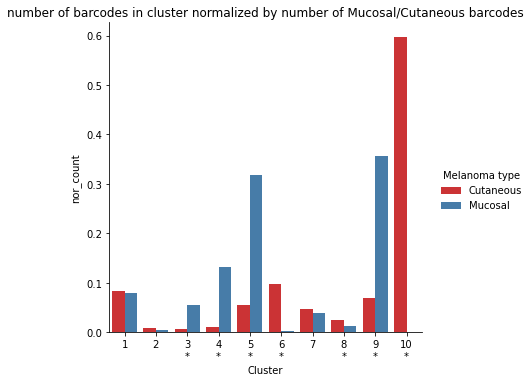

In [34]:
n_cells_in_group_df = df.groupby(['Melanoma type']).agg(count=('Barcode', 'count')).reset_index()
n_cells_in_cluster_df = df.groupby(['Cluster', 'Melanoma type']).agg(count=('Barcode', 'count')).reset_index()
pvals = []
ratios = []
diffs = []
for cluster_idx in sorted(df['Cluster'].unique().tolist()):
    n_cells_g1_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Melanoma type']=='Cutaneous')]['count'].values,np.array([0])))[0]
    n_cells_g1_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Melanoma type']=='Cutaneous']['count'].values[0] - n_cells_g1_in_cluster
    
    n_cells_g2_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Melanoma type']=='Mucosal')]['count'].values,np.array([0])))[0]
    n_cells_g2_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Melanoma type']=='Mucosal']['count'].values[0] - n_cells_g2_in_cluster
    oddsratio, pvalue = stats.fisher_exact([[n_cells_g1_in_cluster, n_cells_g2_in_cluster],[n_cells_g1_not_in_cluster, n_cells_g2_not_in_cluster]])
    g1_r = (n_cells_g1_in_cluster / n_cells_g1_not_in_cluster) + 0.000001
    g2_r = (n_cells_g2_in_cluster / n_cells_g2_not_in_cluster) + 0.000001
    diff = abs(g1_r - g2_r)
    
    ratio = abs(max(g1_r, g2_r) / min(g1_r, g2_r))

    condition = pvalue < 0.05 and (ratio > 1.5 or diff > 0.1)
    
    pvals.append(pvalue)
    ratios.append(ratio)
    diffs.append(diff)
#     print(f'cluster = {cluster_idx},\tratio = {round(ratio,3)},\tdiff = {round(diff,4)},\tpvalue = {round(pvalue,4)},\tconidtion = {condition}')
pvals = np.array(pvals)
ratios = np.array(ratios)
diffs = np.array(diffs)

# Correct pvals
print('With corrected pvals!')
pvals = multipletests_fdr(pvals)[1] < 0.05
condition = pvals & (ratios > 1.5) | (diffs > 0.1)
tr_lbl = {True: '*', False:''}

for i in sorted(df['Cluster'].unique().tolist()):
    print(f'cluster = {i},\tratio = {round(ratios[i-1],3)},\tdiff = {round(diffs[i-1],4)},\tpval<0.05= {pvals[i-1]},\tcondition = {condition[i-1]}')


cutaneous_nor = cutaneous_counts/n_cutaneous
mucosal_nor = mucosal_counts/n_mucosal
# print('Normalized by number of barcodes in group (Mucosal/Cutaneous):')
count_df = df.groupby(['Melanoma type', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_cutaneous if x['Melanoma type']=='Cutaneous' else x['count']/n_mucosal ,axis=1)
count_df['Cluster'] = count_df['Cluster'].apply(lambda x: str(x)+'\n'+tr_lbl[condition[x-1]])
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Melanoma type', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of Mucosal/Cutaneous barcodes')